In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation

In [165]:
def random_flower_attraction(features=2, num_flowers = 10, max_attraction = 10):
    # Random initial condition, only positive, numbers between 0 and max_attraction
    return np.random.rand(features, num_flowers) * max_attraction
def random_flower_position(num_flowers = 10, max_position = 10):
    # Random initial condition, only positive, numbers between 0 and max_position
    return np.random.rand(2, num_flowers) * max_position
def random_bee_position(num_bees = 10, max_position = 10):
    # Random initial condition x and y, only positive coordinates
    return np.random.rand(2, num_bees) * max_position
def random_bee_attraction(features=2, num_bees = 10, max_attraction=10):
    # Random initial condition, only positive, numbers between 0 and max_attraction
    return np.random.rand(features, num_bees) * max_attraction
def gauss_dist(norms, alpha):
    # Gaussian distance function
    return np.exp(-alpha*(norms**2))

In [18]:
# def attraction_to_flower_old(mutual_attraction, mutual_distances, sigma=1):
#     """
#     Params:
#         mutual_attraction: features x num_flowers 
#         mutual_distances: 2 x num_flowers
#         max_velocity: float
#     """
#     # find the unit vector of the velocity, handle the case where the distance is 0
#     velocity_unit_vector = mutual_distances / (np.linalg.norm(mutual_distances, axis=0) + 1e-8)
#     # normalize the distance and divide by the norm of the attraction vectors plus 1
#     return (velocity_unit_vector * gauss_dist(mutual_distances, sigma)) / (1 + np.linalg.norm(mutual_attraction, axis=0))

In [56]:
flower_qnty = 10
bee_qnty = 8
max_attraction = 10
max_position = 10
features = 2
flower_positions = random_flower_position(num_flowers=flower_qnty, max_position=max_position)
bee_positions = random_bee_position(num_bees=bee_qnty, max_position=max_position)
bee_preferences = random_bee_attraction(features=features, num_bees=bee_qnty, max_attraction=max_attraction)
flower_attraction = random_flower_attraction(num_flowers=flower_qnty, features=features, max_attraction=max_attraction)

# Step 2: Compute the differences
attraction_differences = bee_preferences[:, :, np.newaxis] - flower_attraction[:, np.newaxis, :]  # Shape -> (num_features, num_bees, num_flowers)
# distances = bee_positions[:, :, np.newaxis] - flower_positions[:, np.newaxis, :]  # Shape -> (num_features, num_bees, num_flowers)

In [31]:
# def ode(t, x, nu, xsi, sigma):
#     # Reshape x to be compatible with flower_positions
#     bee_positions = x.reshape((2, -1))
#     # Calculate the distance from each bee to each flower
#     distance = bee_positions[:, :, np.newaxis] - flower_positions[:, np.newaxis, :] 
#     # Calculate the velocity vector for each bee towards each flower
#     velocity_vector = attraction_to_flower(attraction_differences, distance, sigma)
#     # Sum the influences of all flowers and normalize
#     velocity = nu * velocity_vector.sum(axis=1) / (xsi + np.linalg.norm(velocity_vector.sum(axis=1), axis=0, keepdims=True))
#     return velocity.flatten()

def ode(t, x, nu, xsi, sigma, gamma, T_i, decay_factor, eps):
    bee_positions = x.reshape((2, -1))
    distance = bee_positions[:, :, np.newaxis] - flower_positions[:, np.newaxis, :] 

    # Update gamma based on the current time and visitation status
    gamma = gamma_update(gamma, decay_factor=decay_factor, t=t, T_i=T_i)

    velocity_vector = attraction_to_flower(attraction_differences, distance, gamma, sigma)
    velocity = nu * velocity_vector.sum(axis=1) / (xsi + np.linalg.norm(velocity_vector.sum(axis=1), axis=0, keepdims=True))
    # print the trajectory points of bee # 2
    # print(velocity[1, :])
    
    # Check and update visitation status
    for i, d in enumerate(distance.T):  # Loop over flowers
        if np.any(np.linalg.norm(d, axis=0) < eps):  # Check if any bee is close enough to the flower
            T_i[i] = t if T_i[i] == -1 else T_i[i]  # Update the visitation time if not previously visited

    return velocity.flatten()

# # Initialize positions and preferences
# flower_positions = random_flower_position(num_flowers=flower_qnty, max_position=max_position)
# bee_positions = random_bee_position(num_bees=bee_qnty, max_position=max_position)
# bee_preferences = random_bee_attraction(features=features, num_bees=bee_qnty, max_attraction=max_attraction)
# flower_attraction = random_flower_attraction(num_flowers=flower_qnty, features=features, max_attraction=max_attraction)

# Calculate the differences in attraction
attraction_differences = bee_preferences[:, :, np.newaxis] - flower_attraction[:, np.newaxis, :]

# # Solve the ODE for the trajectories of the bees
# sol = solve_ivp(ode, [0, 100], bee_positions.flatten(), args=(3, 1, .5), dense_output=True)
# Gamma and Time of Visit Initialization
n = flower_qnty  # Number of flowers
gamma = np.ones(n)  # Initialize gamma as a vector of ones
T_i = -np.ones(n)  # Initialize T_i as a vector of negative ones (indicating no visits yet)
seconds_at_flower = 1.0  # Decay rate for gamma
eps = 1  # Epsilon for distance to flower

# Parameters for the ODE
nu = 10
xsi = 1
alpha = 1

# Define the time span for the simulation
t_span = [0, 100]  # Start and end times

# Flatten the initial bee positions for solve_ivp
initial_conditions = bee_positions.flatten()

# Call solve_ivp
solution = solve_ivp(ode, t_span, initial_conditions, args=(nu, xsi, alpha, gamma, T_i, seconds_at_flower, eps), dense_output=True)

# Extract the solution
trajectory = solution.sol


# # Define time points at which to evaluate the solution
# time_points = np.linspace(t_span[0], t_span[1], t_span[1] * 10)
# trajectories = solution.sol(time_points)

# # Plotting
# plt.figure(figsize=(10, 6))

# num_bees = bee_qnty  # Number of bees
# for i in range(num_bees):
#     # Extracting the x and y coordinates of the i-th bee
#     x = trajectories[i, :]
#     y = trajectories[num_bees + i, :]
#     plt.plot(x, y, label=f'Bee {i+1}')
# # plot the flowers
# plt.scatter(flower_positions[0, :], flower_positions[1, :], label='Flowers')
# # plot the starting positions of the bees
# plt.scatter(bee_positions[0, :], bee_positions[1, :], label='Starting Positions')
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('Trajectories of Bees')
# plt.legend()
# plt.show()

# # print the trajectory points of bee # 6
# print(trajectories[5, :])




In [92]:
def ode(t, x, nu, xsi, sigma, T_i, decay_factor, eps):
    bee_positions = x.reshape((2, -1))
    distance = bee_positions[:, :, np.newaxis] - flower_positions[:, np.newaxis, :] 

    velocity = nu * velocity_vector.sum(axis=1) / (xsi + np.linalg.norm(velocity_vector.sum(axis=1), axis=0, keepdims=True))
    # print the trajectory points of bee # 2
    # print(velocity[1, :])

    # return velocity.flatten()

ode(0, bee_positions.flatten(), 3, 1, .5, T_i, 1.0, 1)

In [ ]:
# Gamma and Time of Visit Initialization
n = flower_qnty  # Number of flowers
gamma = np.ones(n)  # Initialize gamma as a vector of ones
T_i = -np.ones(n)  # Initialize T_i as a vector of negative ones (indicating no visits yet)
seconds_at_flower = 1.0  # Decay rate for gamma
eps = 0.1  # Epsilon for distance to flower
# Parameters for the ODE
nu = 10
xsi = 1
alpha = 1
# Define the time span for the simulation
t_span = [0, 100]  # Start and end times

In [44]:
def ode(t, bee_positions, gamma, T_i):
    # Calculate the distance from each bee to each flower
    distance = bee_positions[:, :, np.newaxis] - flower_positions[:, np.newaxis, :] 

    # Update gamma based on the current time and visitation status
    gamma = gamma_update(gamma, decay_factor=seconds_at_flower, t=t, T_i=T_i)

    # Calculate the velocity vector for each bee towards each flower
    velocity_vector = attraction_to_flower(attraction_differences, distance, gamma, alpha)
    velocity = nu * velocity_vector.sum(axis=1) / (xsi + np.linalg.norm(velocity_vector.sum(axis=1), axis=0, keepdims=True))
    
    # Print the trajectory points of bee # 2
    print(velocity[1, :])
    
    # Check and update visitation status
    for i, d in enumerate(distance.T):  # Loop over flowers
        if np.any(np.linalg.norm(d, axis=0) < eps):  # Check if any bee is close enough to the flower
            T_i[i] = t if T_i[i] == -1 else T_i[i]  # Update the visitation time if not previously visited

    return velocity  # No need to flatten as we're not flattening the input

# Flatten the initial bee positions for solve_ivp
initial_conditions = bee_positions

# Call solve_ivp
solution = solve_ivp(ode, t_span, initial_conditions, args=(gamma, T_i), dense_output=True)

# Extract the solution
trajectory = solution.sol


# Define time points at which to evaluate the solution
time_points = np.linspace(t_span[0], t_span[1], t_span[1] * 10)
trajectories = solution.sol(time_points)

# Plotting
plt.figure(figsize=(10, 6))

num_bees = bee_qnty  # Number of bees
for i in range(num_bees):
    # Extracting the x and y coordinates of the i-th bee
    x = trajectories[i, :]
    y = trajectories[num_bees + i, :]
    plt.plot(x, y, label=f'Bee {i+1}')
# plot the flowers
plt.scatter(flower_positions[0, :], flower_positions[1, :], label='Flowers')
# plot the starting positions of the bees
plt.scatter(bee_positions[0, :], bee_positions[1, :], label='Starting Positions')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Trajectories of Bees')
plt.legend()
plt.show()

# print the trajectory points of bee # 5
print(trajectories[6, :])





In [24]:
def ode(t, x, nu, xsi, sigma, gamma, T_i, decay_factor, eps):
    bee_positions = x.reshape((2, -1))
    distance = bee_positions[:, :, np.newaxis] - flower_positions[:, np.newaxis, :] 

    # Update gamma based on the current time and visitation status
    gamma = gamma_update(gamma, decay_factor=decay_factor, t=t, T_i=T_i)

    velocity_vector = attraction_to_flower(attraction_differences, distance, gamma, sigma)
    velocity = nu * velocity_vector.sum(axis=1) / (xsi + np.linalg.norm(velocity_vector.sum(axis=1), axis=0, keepdims=True))
    
    # Check and update visitation status
    for i, d in enumerate(distance.T):  # Loop over flowers
        if np.any(np.linalg.norm(d, axis=0) < eps):  # Check if any bee is close enough to the flower
            T_i[i] = t if T_i[i] == -1 else T_i[i]  # Update the visitation time if not previously visited

    return velocity.flatten()

In [45]:
# # Flatten the initial bee positions for solve_ivp
# initial_conditions = bee_positions

# # Call solve_ivp
# solution = solve_ivp(ode, t_span, initial_conditions, args=(nu, xsi, sigma, gamma, T_i, decay_factor, eps), dense_output=True)

# # Extract the solution
# trajectory = solution.sol


# # Define time points at which to evaluate the solution
# time_points = np.linspace(t_span[0], t_span[1], t_span[1] * 10)
# trajectories = solution.sol(time_points)

# # Plotting
# plt.figure(figsize=(10, 6))

# num_bees = bee_qnty  # Number of bees
# for i in range(num_bees):
#     # Extracting the x and y coordinates of the i-th bee
#     x = trajectories[i, :]
#     y = trajectories[num_bees + i, :]
#     plt.plot(x, y, label=f'Bee {i+1}')
# # plot the flowers
# plt.scatter(flower_positions[0, :], flower_positions[1, :], label='Flowers')
# # plot the starting positions of the bees
# plt.scatter(bee_positions[0, :], bee_positions[1, :], label='Starting Positions')
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('Trajectories of Bees')
# plt.legend()
# plt.show()

# # print the trajectory points of bee # 5
# print(trajectories[6, :])




In [ ]:
def ode(t, bee_positions, gamma, T_i):
    # Calculate the distance from each bee to each flower
    distance = bee_positions[:, :, np.newaxis] - flower_positions[:, np.newaxis, :] 

    # Update gamma based on the current time and visitation status
    gamma = gamma_update(gamma, decay_factor=seconds_at_flower, t=t, T_i=T_i)

    # Calculate the velocity vector for each bee towards each flower
    velocity_vector = attraction_to_flower(attraction_differences, distance, gamma, alpha)
    velocity = nu * velocity_vector.sum(axis=1) / (xsi + np.linalg.norm(velocity_vector.sum(axis=1), axis=0, keepdims=True))
    
    # Print the trajectory points of bee # 2
    print(velocity[1, :])
    
    # Check and update visitation status
    for i, d in enumerate(distance.T):  # Loop over flowers
        if np.any(np.linalg.norm(d, axis=0) < eps):  # Check if any bee is close enough to the flower
            T_i[i] = t if T_i[i] == -1 else T_i[i]  # Update the visitation time if not previously visited

    return velocity  # No need to flatten as we're not flattening the input

In [103]:
def attraction_to_flower(attraction_differences, distance, distance_norms, sigma=1):
    """
    Include gamma array to modulate the attraction based on visited flowers.
    Params:
        mutual_attraction: features x num_flowers 
        mutual_distances: 2 x num_flowers
        gamma: array representing the attraction modulation
        max_velocity: float
    """
    # find the norm of the distance and the attraction
    attraction_norm = np.linalg.norm(attraction_differences, axis=0)
    velocity_unit_vector = distance / (distance_norms + 1e-8)
    net_attraction = (velocity_unit_vector * gauss_dist(distance_norms, sigma)) / (1 + attraction_norm**2)

    return net_attraction


In [131]:
eps = 1
t_span = [0, 100]
t_steps = 1000
seconds_at_flower =  5
distance = bee_positions[:, :, np.newaxis] - flower_positions[:, np.newaxis, :]
attraction_differences = bee_preferences[:, :, np.newaxis] - flower_attraction[:, np.newaxis, :]  # Shape -> (num_features, num_bees, num_flowers)
distance_norms = np.linalg.norm(distance, axis=0)
T_i = np.ones((bee_qnty, flower_qnty))
def ode(t, x, gamma, T_i):
    distance = x[:, :, np.newaxis] - flower_positions[:, np.newaxis, :] 


    distance_norms = np.linalg.norm(distance, axis=0)
    T_i -= (distance_norms < eps) * ((t_span[1] / t_steps) * (1 / seconds_at_flower))
    gamma = T_i > 0

    print(T_i.shape)
    print(gamma.shape)

    attractors = attraction_to_flower(attraction_differences, distance, distance_norms, alpha)
    attractors = attractors*gamma[np.newaxis, :, :]

    combined_vector = (gamma * attractors).sum(axis=2)
    
    velocity = (nu * combined_vector) / (xsi + combined_vector)

    # return the velocity for each bee
    return velocity


    # velocity = nu * velocity_vector.sum(axis=1) / (xsi + np.linalg.norm(velocity_vector.sum(axis=1)))
    # buzz_factor = np.array([x[0],x[1]]) + 5*np.sin(2*t)*(buzz_factor/(np.linalg.norm(buzz_factor)+1))
    # return velocity 

ode(0, bee_positions, gamma, T_i)


(8, 10)
(8, 10)


array([[ 2.28741439e-15, -1.28427851e-14, -3.09358974e-15,
        -1.95029319e-15,  6.95046469e-15,  5.80197690e-16,
        -1.24996294e-15,  1.25542530e-15],
       [ 1.86684929e-15,  4.13144627e-15,  3.38485994e-15,
         8.69881701e-16,  3.51298052e-15, -2.52526157e-15,
         1.47546390e-14,  1.55147746e-14]])

(12,)


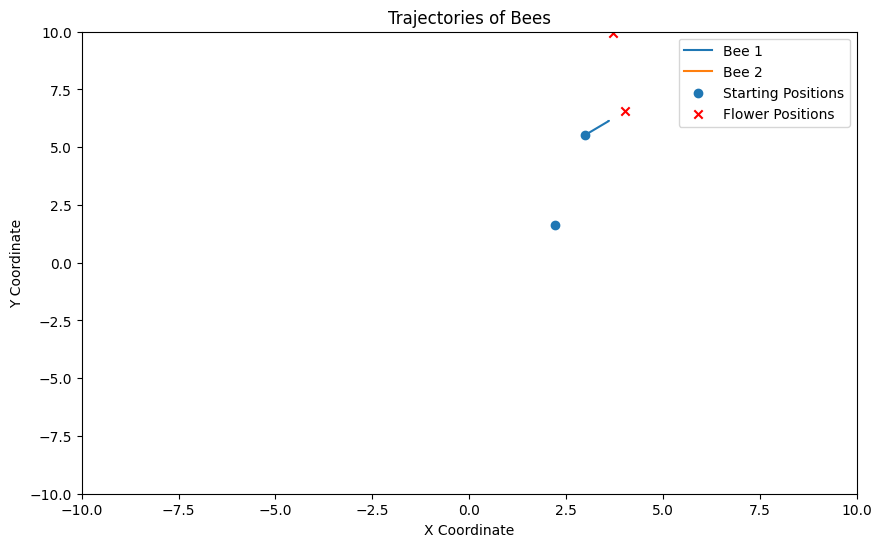

In [232]:
# Define parameters and initial conditions
t_span = [0, 1000]  # Time span for the simulation
t_steps = 10000
nu = 100  # Parameter for the ODE
xsi = 0.2  # Parameter for the ODE
alpha = 3  # Parameter for the ODE
eps = 0.5  # Proximity threshold for flower visitation

flower_qnty = 2
bee_qnty = 2
max_attraction = 10
max_position = 10
features = 2
flower_positions = random_flower_position(num_flowers=flower_qnty, max_position=max_position)
bee_positions = random_bee_position(num_bees=bee_qnty, max_position=max_position)
bee_preferences = random_bee_attraction(features=features, num_bees=bee_qnty, max_attraction=max_attraction)
flower_attraction = random_flower_attraction(num_flowers=flower_qnty, features=features, max_attraction=max_attraction)


seconds_at_flower =  1
attraction_differences = bee_preferences[:, :, np.newaxis] - flower_attraction[:, np.newaxis, :]  # Shape -> (num_features, num_bees, num_flowers)
T_i = np.ones((bee_qnty, flower_qnty))
def ode(t, x_flat, T_i):

    # Reshape x back to its original 2D shape
    x = x_flat.reshape((2, -1))
    distance = flower_positions[:, np.newaxis, :] - x[:, :, np.newaxis]
    distance_norms = np.linalg.norm(distance, axis=0)
    T_i -= (distance_norms < eps) * ((t_span[1] / t_steps) * (1 / seconds_at_flower))
    gamma = T_i > 0
    # print(T_i)

    # print(T_i.shape)
    # print(gamma.shape)

    attractors = attraction_to_flower(attraction_differences, distance, distance_norms, alpha)
    attractors = attractors*gamma[np.newaxis, :, :]

    combined_vector = (gamma * attractors).sum(axis=2)
    
    velocity = (nu * combined_vector) / (xsi + combined_vector)

    # return the velocity for each bee
    return velocity.flatten()

# ode(0, bee_positions, T_i)

solution = solve_ivp(ode, t_span, bee_positions.flatten(), args=(T_i,), dense_output=True)



# Extract the solution
trajectories = solution.y

# Reshape the trajectories to (2, num_bees, num_time_points)
num_bees = bee_qnty
num_time_points = trajectories.shape[1]
trajectories_reshaped = trajectories.reshape((2, num_bees, num_time_points))

plt.figure(figsize=(10, 6))



for i in range(num_bees):
    # Extracting the x and y coordinates of the i-th bee
    x = trajectories_reshaped[0, i, :]
    y = trajectories_reshaped[1, i, :]
    plt.plot(x, y, label=f'Bee {i+1}')

plt.scatter(bee_positions[0, :], bee_positions[1, :], label='Starting Positions')
# plot the flowers
plt.scatter(flower_positions[0, :], flower_positions[1, :], marker='x', color='r', label='Flower Positions')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Trajectories of Bees')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.legend()

plt.show()
# # Solve the ODE system
# # solution = solve_ivp(ode, t_span, bee_positions, args=(gamma, T_i), dense_output=True)

# # Evaluate the trajectories at defined time points
# time_points = np.linspace(t_span[0], t_span[1], t_span[1] * 10)
# trajectories = solution.sol(time_points)

# # Plotting the trajectories
# plt.figure(figsize=(10, 6))
# for i in range(num_bees):
#     # Extracting the x and y coordinates of each bee
#     x = trajectories[i, :]
#     y = trajectories[num_bees + i, :]
#     plt.plot(x, y, label=f'Bee {i+1}')

# # Plot the flowers and starting positions
# plt.scatter(flower_positions[0, :], flower_positions[1, :], label='Flowers')
# plt.scatter(bee_positions[0, :], bee_positions[1, :], label='Starting Positions')

# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('Trajectories of Bees')
# plt.legend()
# plt.show()

# # Print trajectory points of bee # 5 (index 4)
# print(trajectories[4, :])
